# BART Tutorial: Reconstruction of Dynamic Contrast Enhanced (DCE) MRI
## Practical Tools for Applying Compressed Sensing to 2D+Time Data

### Part 1

=========================================================================================================================


This tutorial demonstrates how to build a reconstruction pipeline for Dynamic MRI (2D+Time data) using BART. We demonstrate how to solve the Compressed Sensing optimization problem with different regularizers using BART's Parallel Imaging Compressed Sensing (PICS) command. We focus on a DCE-MRI example. 

Additionally, this notebook shows how to run bart using:
1. The Linux command line
2. The  Python binder

Notice: this notebook should be run using a Python3 kernel.


Efrat Shimron, UC Berkeley (efrat.s@berkeley.edu) and Jon Tamir, UT Austin (jtamir@utexas.edu).

December 2020


# 1. Installation Instructions

### Instructions for running locally on your machine:

1. Install BART - see instructions here: [BART](https://github.com/mrirecon/bart).

2. Add the following three commands to your `.bashrc` file - the first two commands will add BART to your path, and the third command will add BART's python path to your `PATH`: 

`export TOOLBOX_PATH=/path/to/bart`

`export PATH=$TOOLBOX_PATH:$PATH`

`export PYTHONPATH="${TOOLBOX_PATH}/python:$PYTHONPATH"`

3. re-`source` your `.bashrc` or start a new linux session.

### Instructions for running remotely on Binder

If you are running these examples from the Binder, BART should be installed and the necessary paths have already been set. 



### 1.1 BART Installation 

In [1]:
import sys
import os

import numpy as np
from matplotlib import pyplot as plt

It is highly reocmmended to follow the above instructions in order to add BART to your path permanently.
However, if you would like to add BART to your path only for the current session, you can do that by 
de-commenting the next commands and changing the path to your personal path (notice that this will not hold for other sessions!):

In [ ]:
# os.environ['TOOLBOX_PATH'] = '/home/efrat/bart'  ## change to YOUR path
# sys.path.append('/home/efrat/bart/python')       ## change to YOUR path

In [2]:
# After having updated your `PYTHONPATH`, the following commands should execute error-free:
from bart import bart
import cfl


**Optional** -  to display 2D+T figures using SigPy, install Sigpy (https://pypi.org/project/sigpy/) and import its tools as follows (notice that this is not necessary, you can also display images using other libraries, such as matplotlib).


In [3]:
import sigpy as sp
import sigpy.plot as pl
import sigpy.mri as mr

# for displaying figs with Sigpy:
%matplotlib notebook

In [4]:
# check your bart version by running this command - it is recommended to have the most updated version (v0.6.00)
! bart version

v0.6.00


# 2. Data Exploration

## 2.1 Data Loading & Visualing the Dimensions

In this demo we use prospectively under-sampled Dynamic Contrast Enhanced (DCE) MRI data. 
**All the data that is used in this tutorial is courtsey of Prof. Shreyas Vasanawala (Stanford).**

The dataset is located in the folder `data/`.
It consist of:

**ksp** - Under-sampled multi-channel Cartesian k-space data of a single slice. 

**weights** - sampling weights that are used for weighting-down motion-corrupted k-space data. These weights were derived from navigator data. 

Each of these items is stored in BART's ".cfl" (complex-float) format, hence each item has two items: "ksp.cfl" + "ksp.hdr" and "weights.cfl" + "weights.hdr".

In [ ]:
! ls data

### BART's Dimensions Convention

The BART dimensions convention is as follows: 
- dims (0,1,2) - the X,Y,Z dimensions (either in image domain or k-space).
- dim 3 - the coils dimesion.
- dim 4 - the ESPIRiT maps dimension (this enable using multiple sets of ESPIRiT maps). 
- dim 10 (counted with zero-indexing) - the temporal dimension. 


Let's load the data and see its dimension. 

### Option 1: BART's Command Line Interface (CLI)

Here we will exploit the fact that Jupyter notebooks enable running linux command lines when by using "!" in the beginning of the line. This is possible even when the jupyter notebook is running with a python kernel. Since BART's linux interface is very fast it is often conventient to use the CLI for running BART's commands.  

All BART commands are structured in the following way:

`bart` + `command` + `options` + `input/output`

As an example, let's see the dimensions of the k-space data, sensitivity maps and the weights, this time with the BART CLI:

In [5]:
! bart show -m data/ksp

Type: complex float
Dimensions: 16
AoD:	1	68	180	20	1	1	1	1	1	1	18	1	1	1	1	1


In this example the k-space data has these dimensions:

[1,68,180,20,1,1,1,1,1,1,18]

which means that it contains a single kx slice with 68x180 pixels in the kx-ky plane, 20 coils, and 18 time frames. 

In [ ]:
# The weights have dimensions (1,68,180,20,1,1,1,1,1,1,1,18,1,1,1,1) because there is a weight for each pixel in k-space 
# in each time frame, and the weights are identical for all coils (so the coil dims reduced to 1).

# You can see that by running this command:
# ! bart show -m data/weights

### Option 2: cfl.readcfl


The `cfl` library has some helpful tools to save or load BART data into a numpy-compatible format. 
For example, let's read the data from the ksp.cfl file into a numpy array:

In [6]:
ksp = cfl.readcfl('data/ksp')

print(ksp.shape)

(1, 68, 180, 20, 1, 1, 1, 1, 1, 1, 18)


### 2.2 Data exploration cnt'd: Visualizing the sampling mask

In [7]:
# Let's visualize the sampling pattern by looking at a single time frame from k-space.
# First, we will create the pattern using the "bart pattern" command and the CLI. 
# This will create the cfl files (pat.cfl & pat.hdr) in the data folder:
! bart pattern data/ksp   data/pat

In [8]:
# The pattern dimensions are similar to the k-space data dimensions (but with a single coil), since a separate pattern is
# generated for each time frame:
! bart show -m data/pat

Type: complex float
Dimensions: 16
AoD:	1	68	180	1	1	1	1	1	1	1	18	1	1	1	1	1


#### View using matplotlib

In [9]:
# load the data using the cfl.readcfl command:
mask_data = cfl.readcfl('data/pat') 

<IPython.core.display.Javascript object>


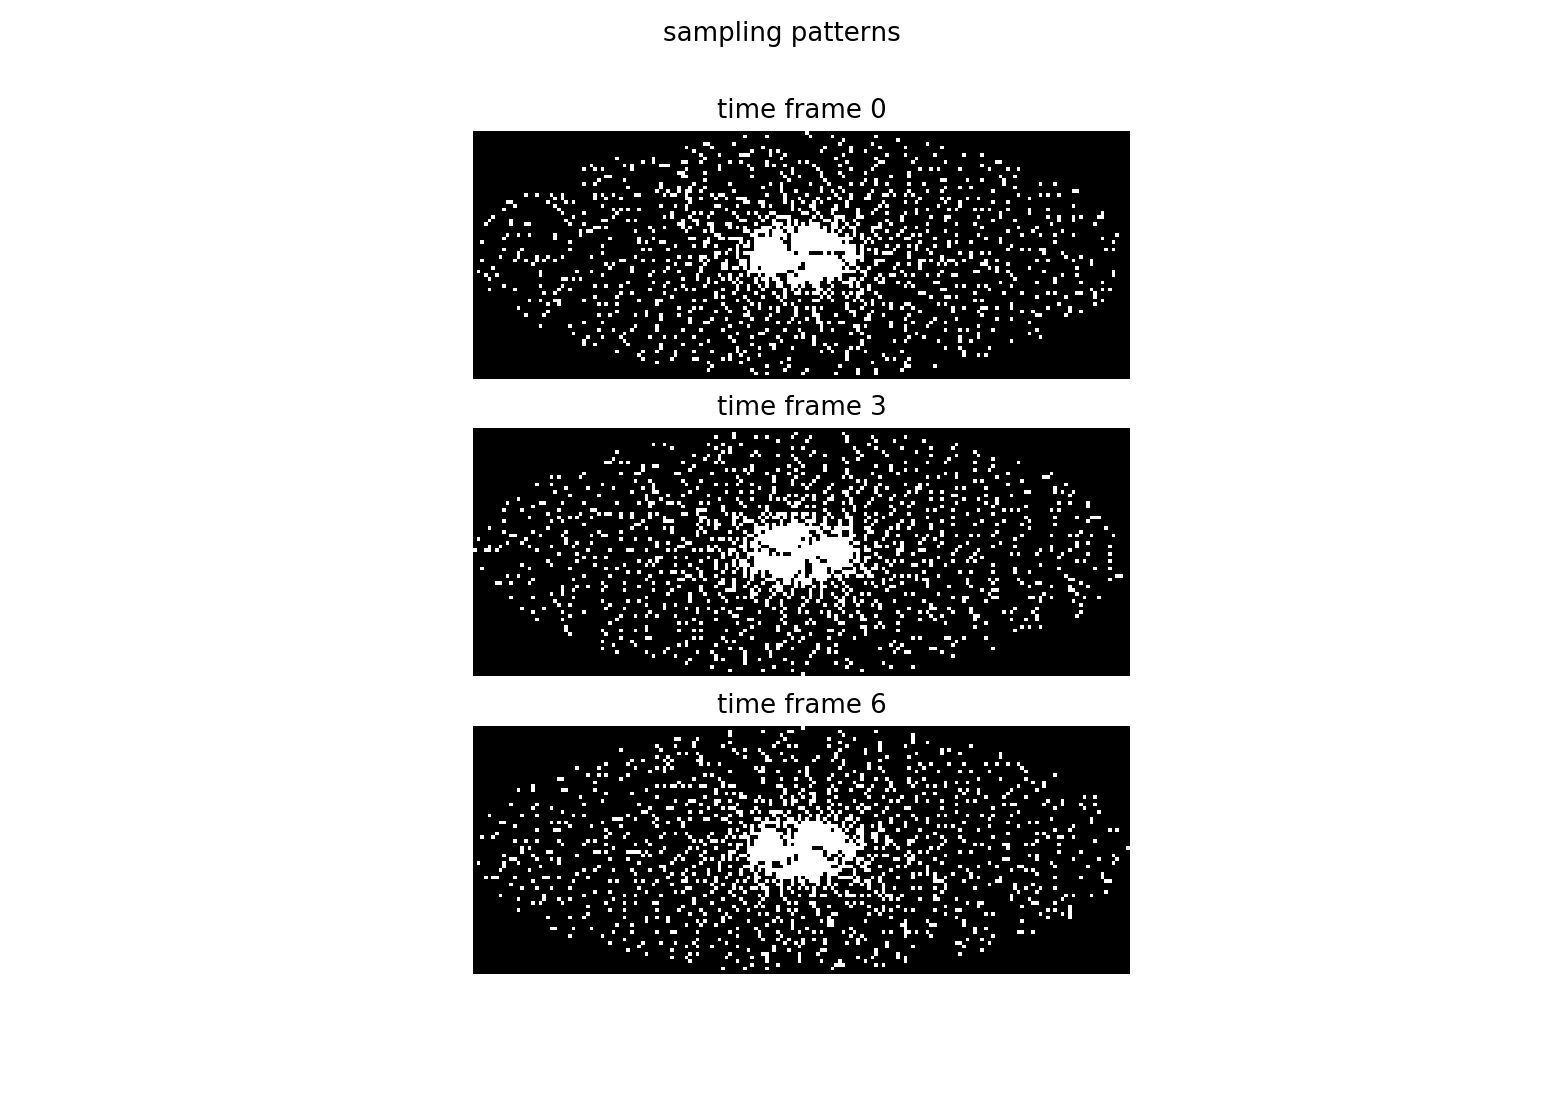

In [11]:
t_ind_vec = np.array([0,3,6])  # choose a single time frame

fig = plt.figure(figsize=(10,7))
for i in range(t_ind_vec.shape[0]):
    t_ind = t_ind_vec[i]
    mask_t_ind = mask_data[0,:,:,0,0,0,0,0,0,0,t_ind].squeeze()
    plt.subplot(3,1,i+1)
    plt.imshow(np.abs(mask_t_ind),cmap="gray")
    plt.title('time frame {}'.format(t_ind))
    plt.axis('off')
plt.suptitle('sampling patterns')
plt.show()

#### Optional - view with Sigpy

moving the temporal dim to the first dim:
(18, 68, 180)


<IPython.core.display.Javascript object>


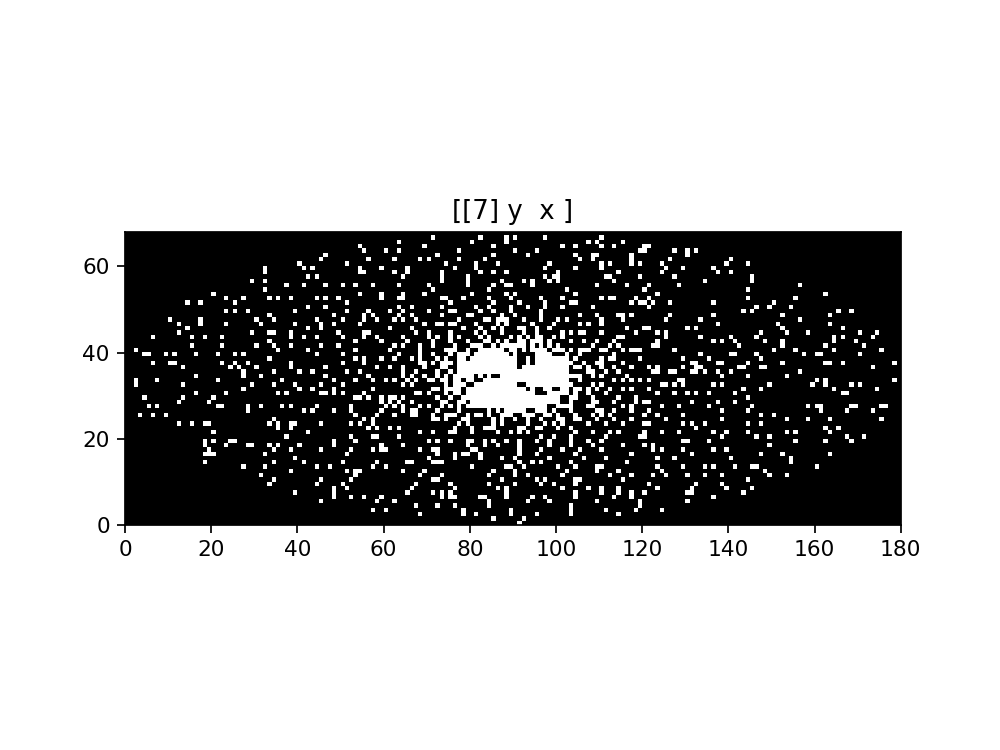

In [12]:
# If you installed the Sigpy package, you can use it to view the sampling mask at all time frames using the following code.
# We need to transpose the data because sigpy assumes that the temporal dimension is the first dimension (0-dim).
# Once the figure is created, use the "up" and "down" arrows on your keyboard to move between images of different time frames.
# To do that, look at the title of the plot - you will see something like [[9] y x]. The inner square brackets around the first
# number indicate that we will page through different images along this dimension. In case your data is 3D and you want to
# slice and view it in different ways, you can also use the "right" and "left" arrows of your keyboard to move the square 
# brackets to a different dimension and page through it.

print('moving the temporal dim to the first dim:')
mask_all_time_frames = mask_data[0,:,:,0,0,0,0,0,0,0,:].squeeze()
mask_all_time_frames = np.transpose(mask_all_time_frames,(2,0,1))
print(mask_all_time_frames.shape)

# display using Sigpy
pl.ImagePlot(mask_all_time_frames)

# 3. Sensitivity Maps Estimation


In this section we will estimate the sensitivity maps from the (prospectively) under-sampled k-space data.
When working with dynamic (2D+Time or 3D+Time) data, it is common practice to compute the sensitivity maps as follows:

1. Compute the average of k-space data over time.
2. Use ESPIRiT (bart ecalib) to compute the sensitivity maps from the time-averaged k-space data.

In this tutorial we will do that twice in order to demonstrate BART's two useful interfaces - the linux command line interface and the python binder.

#### 1. Compute the time-average of k-space data

In [13]:
# First let's compute the average of k-space data along the temporal domain. Since k-space is prospectively under-sampled,
# some of the k-space pixels have zero values. Here we use the command "bart avg -w", which does not account for zeros 
# in the average (i.e. zeros are thrown out). The time-averaged k-space data will be saved in the cfl format in the files
# ksp_t_avg.cfl and ksp_t_avg.hdr

! bart avg -w $(bart bitmask 10) data/ksp  data/ksp_t_avg

! bart show -m data/ksp_t_avg

Type: complex float
Dimensions: 16
AoD:	1	68	180	20	1	1	1	1	1	1	1	1	1	1	1	1


#### 2. Compute the sensitivity maps 
get help about ecalib by running ``! bart ecalib -h``

In [14]:
# Next, we will use ecalib to compute the sensitivity maps.
# Here we pre-calibrated the thresholds of ecalib for convenience ("-t 0.02 -c 0.5"), and we compute two sets of ESPIRiT
# maps ("-m2")

! bart ecalib -t 0.02 -c 0.5 -m 2 data/ksp_t_avg  data/maps

# You can also use ecalibs's "-a" flag to have BART compute the thresholds automatically, as follows:
#! bart ecalib -a -m 1 data/ksp_t_avg  data/sens_maps_from_t_avg

Done.


In [15]:
# see dimensions:
! bart show -m data/maps

Type: complex float
Dimensions: 16
AoD:	1	68	180	20	2	1	1	1	1	1	1	1	1	1	1	1


#### Load & display

<IPython.core.display.Javascript object>


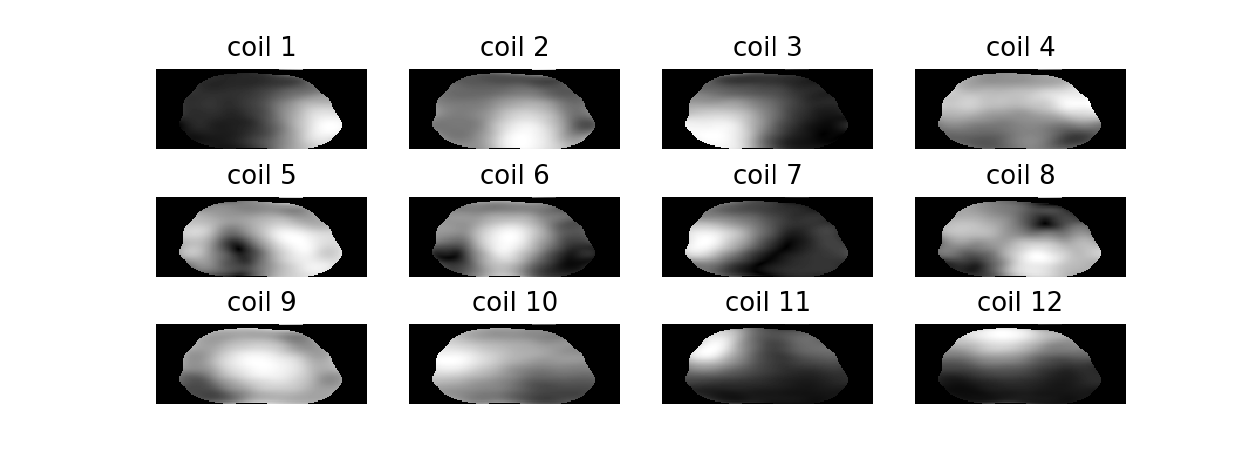

In [16]:
sens_maps = cfl.readcfl('data/maps') 

# display the magnitude of the 1st set of sens maps for the first 12 coils:

ecalib_ind = 0  # use this to view the 1st set of sensitivity maps (since we ran bart ecalib with "-m 2" there are 2 sets)


fig = plt.figure(figsize = (8,3))
for coil_i in range(12):
    sens_map_coil = sens_maps[0,:,:,coil_i,ecalib_ind].squeeze()
    plt.subplot(3,4,coil_i+1)
    plt.imshow(np.abs(sens_map_coil),cmap="gray")
    plt.axis('off')
    plt.title('coil {}'.format(coil_i+1))
plt.show()

## Alternative: same computations - with BART's python binding

### Introduction to BART's python binding

The `bart` module allows a user to execute any BART command-line tool via the following format:

`<outputs> = bart(<nargs>, <command>, <arguments>, ...)`

Where:

`<outputs>`: the output of a BART command

`<nargs>`: the number of outputs

`<command>`: the command string and necessary flags

`<arguments>`: the `<nargs>` data files passed in for use in the function

In [ ]:
# ksp_t_avg = bart(1,"avg -w $(bart bitmask 10) {}".format("data/ksp"))

# sens_maps = bart(1, 'ecalib -t 0.02 -c 0.5 -m 2', ksp_t_avg[:,:,:,:])

# # save (this is optional - you can also continue to work with the numpy array)
# cfl.writecfl('data/maps',sens_maps)

# # display
# fig = plt.figure(figsize = (7,4))
# ecalib_ind = 0  # use this to view the 1st set of sensitivity maps (since we ran bart ecalib with "-m 2" there are 2 sets)

# for coil_i in range(12):
#     sens_map_coil = sens_maps[0,:,:,coil_i,ecalib_ind].squeeze()
#     plt.subplot(3,4,coil_i+1)
#     plt.imshow(np.abs(sens_map_coil),cmap="gray")
#     plt.axis('off')
#     plt.title('coil {}'.format(coil_i+1))
# plt.show()

# Reconstruction 

We will use the `pics` tool to perform ESPIRiT-based parallel imaging and compressed sensing. The basic usage is

    bart pics [optimization options] [regularization options] kspace maps recon
    
See the full list with `bart pics -h`.
There are several built-in regularization terms and transforms. We can see the options by invoking the help:

In [ ]:
! bart pics -h

### Regularization

There are various options for regularization with bart pics. 
To see the different options for pics regularization, use `bart pics -Rh` flag:


In [ ]:
! bart pics -Rh

In the next few sections we will show how to reconstruct the 2D+Time data using different regularizers. 

## Locally Low Rank (LLR) Regularizer in the spatial domain


In [20]:
! bart pics -d5 -i 30 -p data/weights -R L:$(bart bitmask 0 1 2):$(bart bitmask 0 1 2):0.005 data/ksp data/maps data/recon_LLR

2 maps.
ESPIRiT reconstruction.
Size: 220320 Samples: 17236 Acc: 12.78
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Calibration region...  (size: 1x5x2, pos: 0x31x89)
Scaling: 329041.093750! (max = 329041.093750/p90 = 329041.093750/median = 153375.046875)
Inverse scaling of the data: 329041.093750
lowrank regularization: 0.005000
FISTA
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 2-3 of 5.
Linking args 2-3 of 5.
#It 000: 1.000000   
#It 001: 0.266695   
#It 002: 0.116101   
#It 003: 0.065800   
#It 004: 0.041172   
#It 005: 0.026642   
#It 006: 0.018521   
#It 007: 0.014550   
#It 008: 0.012376   
#It 009: 0.010727   
#It 010: 0.009433   
#It 011: 0.008608   
#It 012: 0.008139   
#It 013: 0.007896   
#It 014: 0.007800   
#It 015: 0.007790   
#It 016: 0.007836   
#It 017: 0.007867   
#It 018: 0.007816   
#It 019: 0.007866   
#It 020: 0.007952   
#It 021: 0.007944   
#It 022: 0.0079

<IPython.core.display.Javascript object>


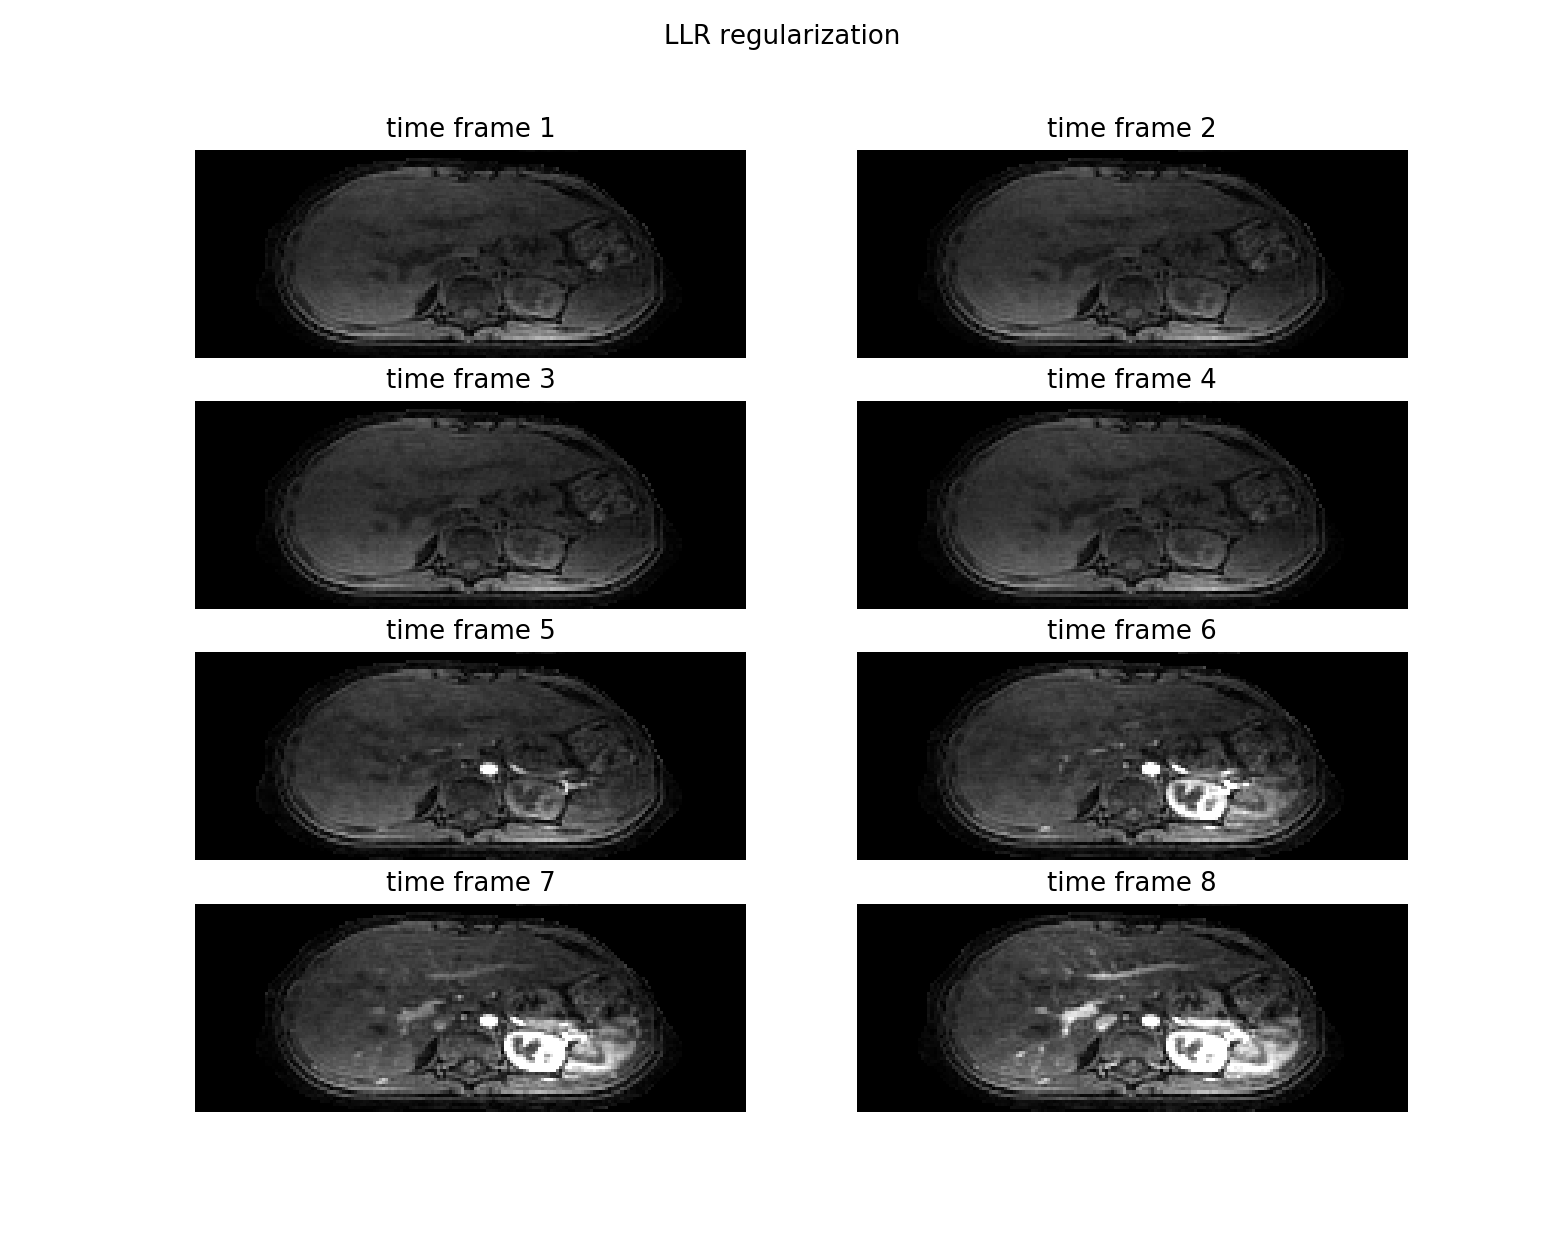

In [21]:
# Load & view the reconstruction
recon_LLR = cfl.readcfl('data/recon_LLR')
recon_LLR_sqz = recon_LLR[0,:,:,0,0,0,0,0,0,0,:].squeeze()

# display - let's view the first 8 time frames (of 20)
fig = plt.figure(figsize = (10,8))
for t_ind in range(8):
    im_frame = recon_LLR_sqz[:,:,t_ind].squeeze()
    plt.subplot(4,2,t_ind+1)
    plt.imshow(np.abs(im_frame),cmap="gray")
    plt.clim(0,5)
    plt.axis('off')
    plt.title('time frame {}'.format(t_ind+1))

plt.suptitle('LLR regularization')
plt.show()



<IPython.core.display.Javascript object>


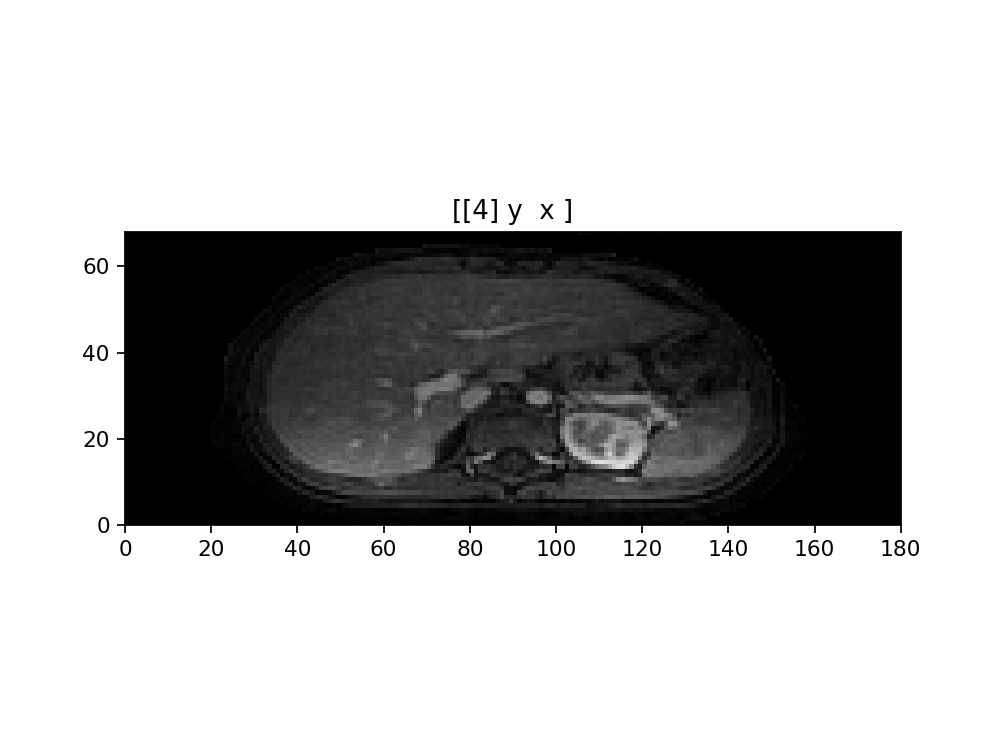

In [22]:
# view with Sigpy
recon_LLR_sqz = recon_LLR[0,:,:,0,0,0,0,0,0,0,:].squeeze()
recon_LLR_transpose = np.moveaxis(recon_LLR_sqz,-1,0) # to display with SigPy, move the temporal dim to the 0-dim.
recon_LLR_rotated = np.rot90(recon_LLR_transpose,2)

pl.ImagePlot(recon_LLR_rotated)

# Example - How to Correct the Aspect Ratio
In this example k-space data was acquired with different pixel sizes along the y and z dimensions. As a result, we see 'squashed' images. We can correct this by zero-padding the data in k-pace to the correct dimensions. Notice - This requires knowledge of the true FOV that was used in the scan. 


In [25]:
#### Interp in image domain (zero-pad in k-space)
! bart fft -u $(bart bitmask 0 1 2) data/recon_LLR  data/recon_LLR_FT
! bart resize -c 1 100 data/recon_LLR_FT  data/recon_LLR_FT_padded
! bart fft -u -i  $(bart bitmask 0 1 2) data/recon_LLR_FT_padded  data/recon_LLR_interp


<IPython.core.display.Javascript object>


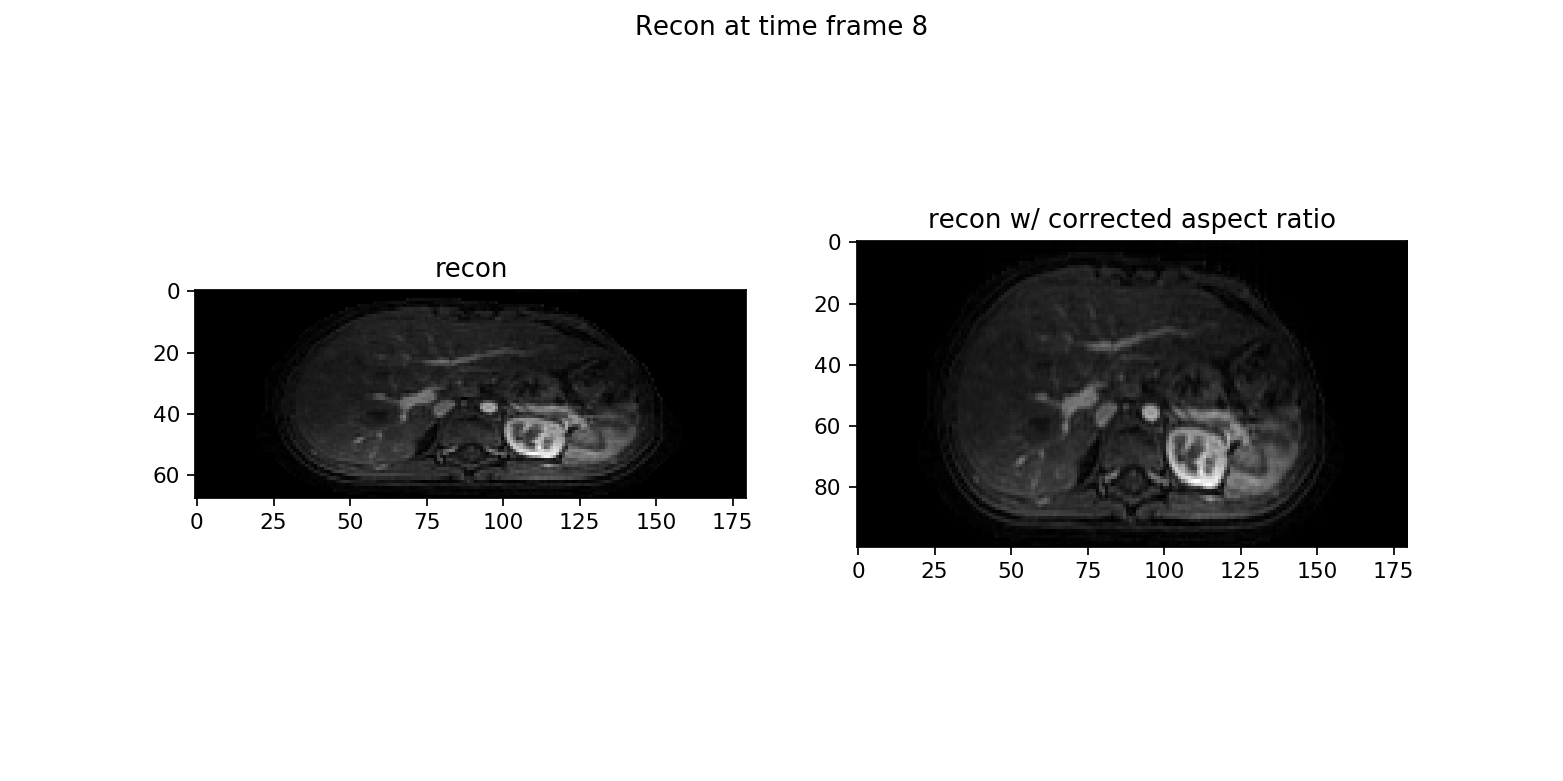

In [26]:
# Load & view the reconstruction
recon_LLR_interp = cfl.readcfl('data/recon_LLR_interp')

# squeeze dims
recon_LLR_interp_sqz = recon_LLR_interp[0,:,:,0,0,0,0,0,0,0,:].squeeze()

t_ind = 8
recon_LLR_sqz_t = recon_LLR_sqz[:,:,t_ind]  # original recon - before interpolation
recon_LLR_interp_sqz_t = recon_LLR_interp_sqz[:,:,t_ind]  # recon with fixed aspect ratio - 

fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(np.abs(recon_LLR_sqz_t),cmap="gray")
plt.title('recon')

plt.subplot(1,2,2)
plt.imshow(np.abs(recon_LLR_interp_sqz_t),cmap="gray")
plt.title('recon w/ corrected aspect ratio')
plt.suptitle('Recon at time frame {}'.format(t_ind))
plt.show()



# Hands-on Tutorial with a new dataset
We prepared a second dataset for you to experiment with. This dataset is in the folder ``data_ccomp``.
This data also contains a single 2D+Time "slice" of k-space data acquired in a pediatric DCE scan at Stanford.
However, it has different dimensions than the previous dataset, and it has already been coil-compressed such that it now has six virtual coils.

In [27]:
# Let's see the dimensions of this dataset:
! bart show -m data_ccomp/ksp_slice_80

Type: complex float
Dimensions: 16
AoD:	1	180	80	6	1	1	1	1	1	1	18	1	1	1	1	1


In [ ]:
# Here we compute the ESPIRIT sensitivity maps using bart ecalib. We take a slightly different approach - instead of 
# computing them from the time-averaged data, we compute them from the k-space data of the first time frame.
# For that, we first slice the data along the temporal domain (dimension 10).

# slicing:
! bart slice 10 0 data_ccomp/ksp_slice_80  data_ccomp/ksp_slice_80_t0

# ESPIRiT:
! bart ecalib -a data_ccomp/ksp_slice_80_t0  data_ccomp/sens_maps_slice_80

### Do your own DCE recon!

It's time to do your first DCE recon!
In the folder data_ccomp you'll find the files that we prepared for you:
1. data_ccomp/ksp_slice_80' - kspace of a 2D+Time slice
2. data_ccomp/sens_maps_slice_80' - sensitivity maps

Now write your own code for a reconstruction with LLR regularization.
Please save your result with the following filename:

data_ccomp/rec_LLR

**Hint**: use block size in the range 8-10 and lambda in the range 0.005-0.01

In [ ]:

###### Exercise ######

# Your code goes here!
# ! bart pics...

# output filename should be: data_ccomp/recon_LLR

########################



In [ ]:
rec_LLR = cfl.readcfl('data_ccomp/recon_LLR')
print(rec_LLR.shape)

# # squeeze dims
rec_LLR_sqz = rec_LLR[:,:,:,0,0,0,0,0,0,:].squeeze()
print(rec_LLR_sqz.shape)

rec_LLR_t_xy = np.transpose(rec_LLR_sqz,(2,1,0))
print(rec_LLR_t_xy.shape)

# %matplotlib notebook
pl.ImagePlot(np.abs(rec_LLR_t_xy))

# fig = plt.figure()
# im = rec_LLR_sqz[:,:,12].squeeze()
# plt.imshow(np.rot90(np.abs(im),1),cmap="gray")
# plt.show()

#### Correct the Aspect Ratio (zero-pad in k-space)

In [ ]:
! bart fft -u $(bart bitmask 0 1 2) data_ccomp/recon_LLR  data_ccomp/recon_LLR_FT
! bart resize -c 2 224 data_ccomp/recon_LLR_FT  data_ccomp/recon_LLR_FT_padded
! bart resize -c 1 280 data_ccomp/recon_LLR_FT_padded  data_ccomp/recon_LLR_FT_padded2
! bart fft -u -i  $(bart bitmask 0 1 2) data_ccomp/recon_LLR_FT_padded2  data_ccomp/recon_LLR_interp


In [ ]:
# Load & view the reconstruction
rec_LLR_interp = cfl.readcfl('data_ccomp/recon_LLR_interp')

# squeeze dims
rec_LLR_interp_sqz = rec_LLR_interp[0,:,:,0,0,0,0,0,0,0,:].squeeze()

rec_LLR_interp_sqz_12 = rec_LLR_interp_sqz[:,:,11].squeeze()
rec_LLR_interp_sqz_12 = np.rot90(rec_LLR_interp_sqz_12,1)

fig = plt.figure(figsize=(8,4))
plt.imshow(np.abs(rec_LLR_interp_sqz_12),cmap="gray")
plt.title("frame 12")
plt.show()

In [ ]:
# Load & view the reconstruction with Sigpy
rec_LLR_interp = cfl.readcfl('data_ccomp/recon_LLR_interp')

# squeeze dims
rec_LLR_interp_sqz = rec_LLR_interp[0,:,:,0,0,0,0,0,0,0,:].squeeze()

rec_LLR_interp_t_xy = np.moveaxis(rec_LLR_interp_sqz,-1,0) # to display with SigPy, move the temporal dim to the 0-dim.
rec_LLR_interp_t_xy = np.transpose(rec_LLR_interp_t_xy,(0,2,1))
%matplotlib notebook
pl.ImagePlot(rec_LLR_interp_t_xy)

We hope you enjoyed this tutorial!

Efrat & Jon

PS. You can find the solution of the hands-on exercise in the file LR_solution.txt in this repo